In [191]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout,SimpleRNN,Bidirectional
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import *
from sklearn.model_selection import *
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Yahoo Finance
import yfinance as yf

from ta.trend import SMAIndicator
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands


In [192]:
data = yf.download("AAPL") #stock info  Apple
df = pd.DataFrame(data)
df.head()
dfa = df.copy()


[*********************100%***********************]  1 of 1 completed


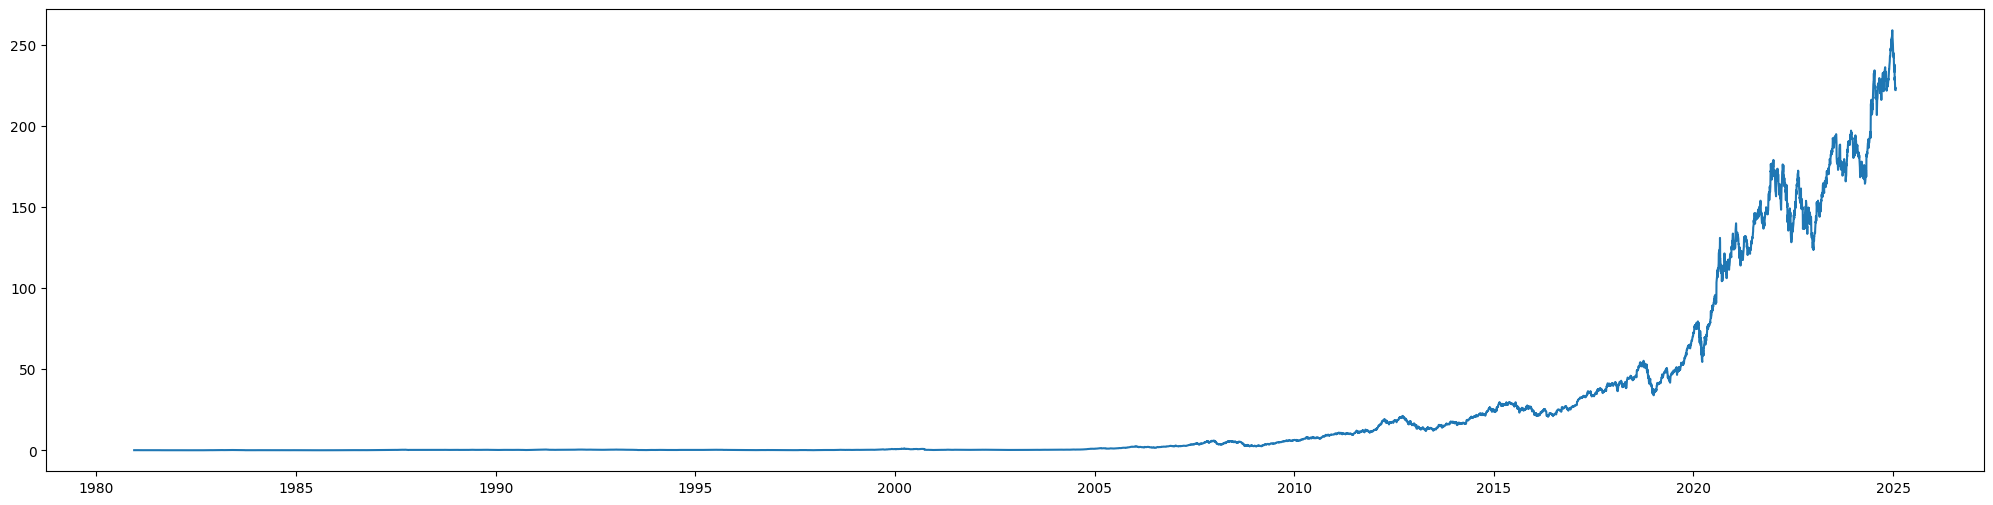

In [193]:
plt.figure(figsize=(25, 6))
plt.plot(df['Close'],)#close price of stock plot

In [194]:
df['Diff'] = df['Close'] - df['Open']

df['Diff_5'] = df['Diff'].rolling(window=5).sum()#rolling sum of 5 days
df['Diff_30'] = df['Diff'].rolling(window=30).sum()#rolling sum of 30 days


In [195]:
df['SMA_20'] = SMAIndicator(close=df['Close'].squeeze() , window=20).sma_indicator()#simple moving average

# Relative Strength Index (RSI)
df['RSI_14'] = RSIIndicator(close=df['Close'].squeeze(), window=14).rsi()

# Bollinger Bands
bb = BollingerBands(close=df['Close'].squeeze(), window=20, window_dev=2)
df['Upper_BB'] = bb.bollinger_hband()
df['Lower_BB'] = bb.bollinger_lband()
df = df.dropna()
df.columns = df.columns.droplevel(1)#drop level 1 columns names

df.head()


Price,Close,High,Low,Open,Volume,Diff,Diff_5,Diff_30,SMA_20,RSI_14,Upper_BB,Lower_BB
Date,,,,,,,,,,,,
1981-01-26,0.110867,0.111296,0.110867,0.111296,24640000,-0.000430,-0.001289,-0.006445,0.111533,53.741915,0.122220,0.100845
1981-01-27,0.110007,0.110867,0.110007,0.110867,23699200,-0.000859,-0.001719,-0.007305,0.110845,52.368707,0.119951,0.101740
1981-01-28,0.106570,0.106999,0.106570,0.106999,28156800,-0.000430,-0.002148,-0.007305,0.110136,47.175707,0.118194,0.102078
1981-01-29,0.102702,0.103132,0.102702,0.103132,43904000,-0.000430,-0.002578,-0.007305,0.109406,42.115985,0.117377,0.101434
1981-01-30,0.097116,0.097975,0.097116,0.097975,46188800,-0.000859,-0.003008,-0.008164,0.108331,36.093475,0.116830,0.099833


In [196]:

correlation_matrix = df.corr()
print(correlation_matrix['Close'])


Price
Close       1.000000
High        0.999947
Low         0.999947
Open        0.999885
Volume     -0.267555
Diff        0.066776
Diff_5      0.150932
Diff_30     0.389439
SMA_20      0.998988
RSI_14      0.078295
Upper_BB    0.998770
Lower_BB    0.998532
Name: Close, dtype: float64


In [251]:
X = df[['Open', 'High', 'Low', 'Diff_30','SMA_20','Upper_BB','Lower_BB']].values
y = df['Close'].values
X = X.reshape((X.shape[0], 1, X.shape[1]))  # Shape: (samples, time_steps, features)

# Split data into train and test sets
split_index = int(len(X) * 0.8)  # 80% for training, 20% for testing
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:] 

In [252]:
model = Sequential()

model.add(LSTM(units=150, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))

model.summary()
optimizer = Adam(learning_rate = 0.001)
model.compile(optimizer=optimizer  , loss='mse', metrics=['mae'])

C:\Users\przem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_23 (LSTM)                  │ (None, 1, 150)         │        94,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 1, 150)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1, 1)           │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,951 (370.90 KB)

 Trainable params: 94,951 (370.90 KB)

 Non-trainable params: 0 (0.00 B)

In [253]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
]

history = model.fit(
    X_train, y_train,
    epochs=1000,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
    shuffle=False,
    callbacks=callbacks)

Epoch 1/1000
278/278 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0650 - mae: 0.0777 - val_loss: 219.7687 - val_mae: 11.2233
Epoch 2/1000
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0756 - mae: 0.0952 - val_loss: 614.7598 - val_mae: 18.7510
Epoch 3/1000
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0920 - mae: 0.1297 - val_loss: 67.0328 - val_mae: 5.7521
Epoch 4/1000
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0907 - mae: 0.2136 - val_loss: 262.5391 - val_mae: 12.1825
Epoch 5/1000
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0744 - mae: 0.1473 - val_loss: 130.4825 - val_mae: 8.4245
Epoch 6/1000
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0783 - mae: 0.1788 - val_loss: 135.0692 - val_mae: 8.4731
Epoch 7/1000
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0757 - mae: 0.1531 - val_loss: 66.6176 - val_mae: 5.7478
Epoch 8/1000
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0694 - mae: 0.1272 - val_loss: 87.1196 - val_mae: 6.6661
Epoch 9/1000
278/278 ━━━

<Axes: >

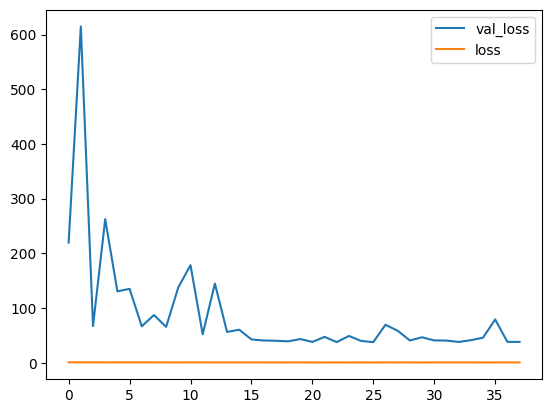

In [254]:
pd.DataFrame({'val_loss':history.history['val_loss'], 'loss' : history.history['loss']}).plot()

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


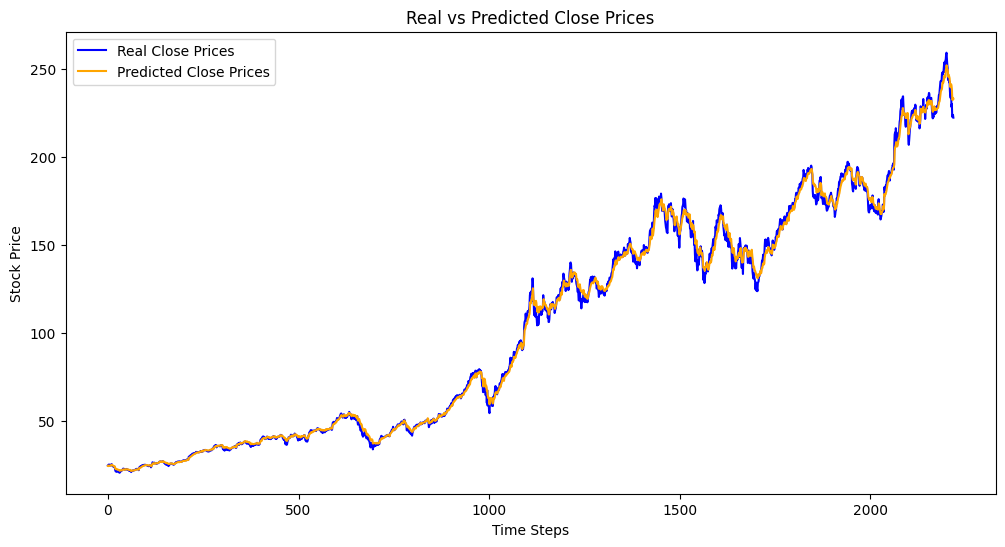

Mean Absolute Error (MAE): 1.9744090243146568
Mean Squared Error (MSE): 8.156895939139737


In [255]:
y_pred = model.predict(X_test)
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label="Real Close Prices", color="blue")
plt.plot(range(len(y_pred)), y_pred.flatten(), label="Predicted Close Prices", color="orange")
plt.title("Real vs Predicted Close Prices")
plt.xlabel("Time Steps")    
plt.ylabel("Stock Price")
plt.legend()
plt.show()

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred.flatten())
mse = mean_squared_error(y_test, y_pred.flatten())
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred.flatten())
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')

Final Money: $1220.63
Final Portfolio Value: $1220.63


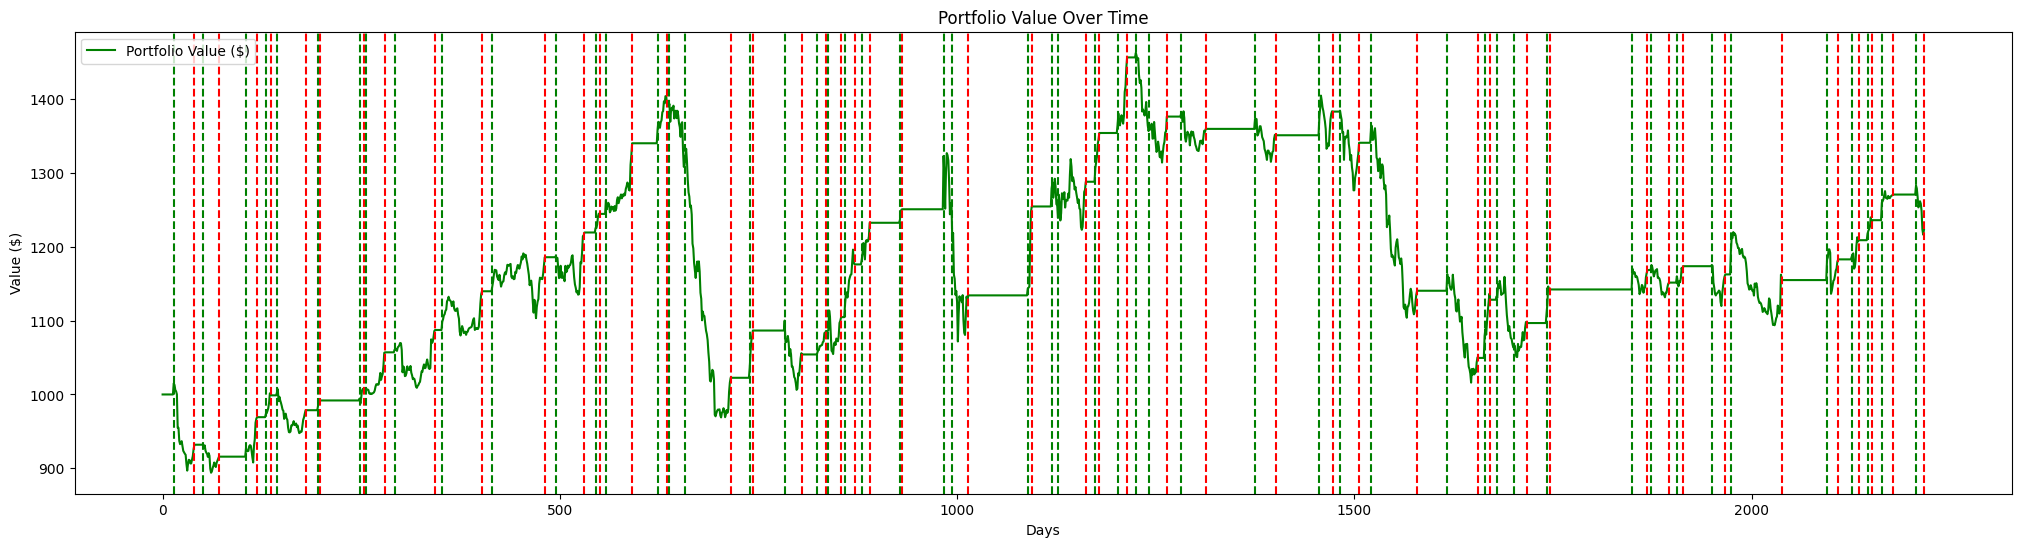

In [256]:
stock = 0
money = 1000
money_log = []
portfolio_value_log = []
buy_counter = 0
sell_counter = 0
#days to wait before buying or selling
buy_threshold = 3
sell_threshold = 3

buy_counter_log=[]
sell_counter_log=[]
# Predicted and actual prices
close_prices = y_pred[:, 0].flatten()  
open_prices = X_test[:, 0, 0].tolist() 

# Simulate trading strategy
for i in range(0, len(close_prices) - 1):
    # Buy logic
    if close_prices[i] > open_prices[i] and money >= open_prices[i]:
        buy_counter += 1
        if buy_counter >= buy_threshold:
            while money >= open_prices[i]:
                stock += 1
                money -= open_prices[i]
            buy_counter_log.append(i)
    else:
        buy_counter = 0  

    # Sell logic
    if close_prices[i] < open_prices[i]:
        sell_counter += 1
        if sell_counter >= sell_threshold and stock > 0:
            money += close_prices[i] * stock  
            stock = 0
            sell_counter_log.append(i)
    else:
        sell_counter = 0  

    portfolio_value = money + stock * close_prices[i]
    portfolio_value_log.append(portfolio_value)
    money_log.append(money)

# Final sell if still holding stock
if stock > 0:
    money += stock * close_prices[-1]
    portfolio_value = money
    sell_counter_log.append(i)
else:
    portfolio_value = portfolio_value_log[-1]

print(f"Final Money: ${money:.2f}")
print(f"Final Portfolio Value: ${portfolio_value:.2f}")

plt.figure(figsize=(25, 6))

plt.plot(portfolio_value_log, label="Portfolio Value ($)", linestyle="-", color="green")


plt.title("Portfolio Value Over Time")
plt.xlabel("Days")
plt.ylabel("Value ($)")
for xi in sell_counter_log:
    plt.axvline(x=xi, linestyle='--', color='r')
for xi in buy_counter_log:
    plt.axvline(x=xi, linestyle='--', color='g')
plt.legend()
plt.show()

# 2nd model predicting trend on market


In [257]:
correlation_matrix = df.corr()
print(correlation_matrix['Diff'])

Price
Close       0.066776
High        0.059119
Low         0.059324
Open        0.051650
Volume     -0.021963
Diff        1.000000
Diff_5      0.467663
Diff_30     0.184655
SMA_20      0.054141
RSI_14      0.109592
Upper_BB    0.053811
Lower_BB    0.054472
Name: Diff, dtype: float64


In [258]:

time_steps = 1

X2 = []
y2 = []

for i in range(time_steps, len(df)):
    X2.append(df[['Open','Close','Diff_5','Diff_30']].values[i-time_steps:i])
    y2.append(df['Diff'].values[i])

X2, y2 = np.array(X2), np.array(y2)

# Split data into train and test sets
split_index = int(len(X2) * 0.8)  # 80% for training, 20% for testing
X2_train, X2_test = X2[:split_index], X2[split_index:]
y2_train, y2_test = y2[:split_index], y2[split_index:]

In [259]:
model2 = Sequential([
    LSTM(150, activation='relu', input_shape=(1,4), return_sequences=True),
    Dropout(0.2),
    Dense(1)
])
model2.summary()
optimizer = Adam(learning_rate = 0.0001)
model2.compile(optimizer=optimizer  , loss='mse', metrics=['mae'])

C:\Users\przem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                  │ (None, 1, 150)         │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 1, 150)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1, 1)           │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,151 (363.87 KB)

 Trainable params: 93,151 (363.87 KB)

 Non-trainable params: 0 (0.00 B)

In [260]:
callbacks2 = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

history2 = model2.fit(
    X2_train, y2_train,
    epochs=1000,
    batch_size=32,
    validation_data=(X2_test, y2_test),
    verbose=1,
    shuffle=False,
    callbacks=callbacks2)

Epoch 1/1000
278/278 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0016 - mae: 0.0107 - val_loss: 8.6153 - val_mae: 2.0015
Epoch 2/1000
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0015 - mae: 0.0113 - val_loss: 7.6159 - val_mae: 1.8546
Epoch 3/1000
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0013 - mae: 0.0132 - val_loss: 5.5884 - val_mae: 1.5555
Epoch 4/1000
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0013 - mae: 0.0155 - val_loss: 4.7707 - val_mae: 1.4321
Epoch 5/1000
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0012 - mae: 0.0113 - val_loss: 3.3848 - val_mae: 1.1899
Epoch 6/1000
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0011 - mae: 0.0097 - val_loss: 2.9440 - val_mae: 1.0991
Epoch 7/1000
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0011 - mae: 0.0095 - val_loss: 2.9004 - val_mae: 1.0843
Epoch 8/1000
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0011 - mae: 0.0101 - val_loss: 3.0317 - val_mae: 1.1098
Epoch 9/1000
278/278 ━━━━━━━━━━━━━━━━━━━

<Axes: >

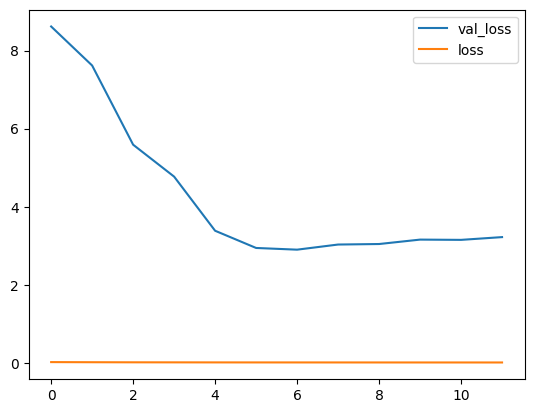

In [261]:
pd.DataFrame({'val_loss':history2.history['val_loss'], 'loss' : history2.history['loss']}).plot()

In [262]:
y2_pred = model2.predict(X2_test)
# Ensure y2_test and y2_pred have the same shape
y2_test_flat = y2_test.flatten()
y2_pred_flat = y2_pred.flatten()[:len(y2_test_flat)]  # Slice to match the length of y2_test_flat

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Final Money: $2123.27
Final Portfolio Value: $2123.27


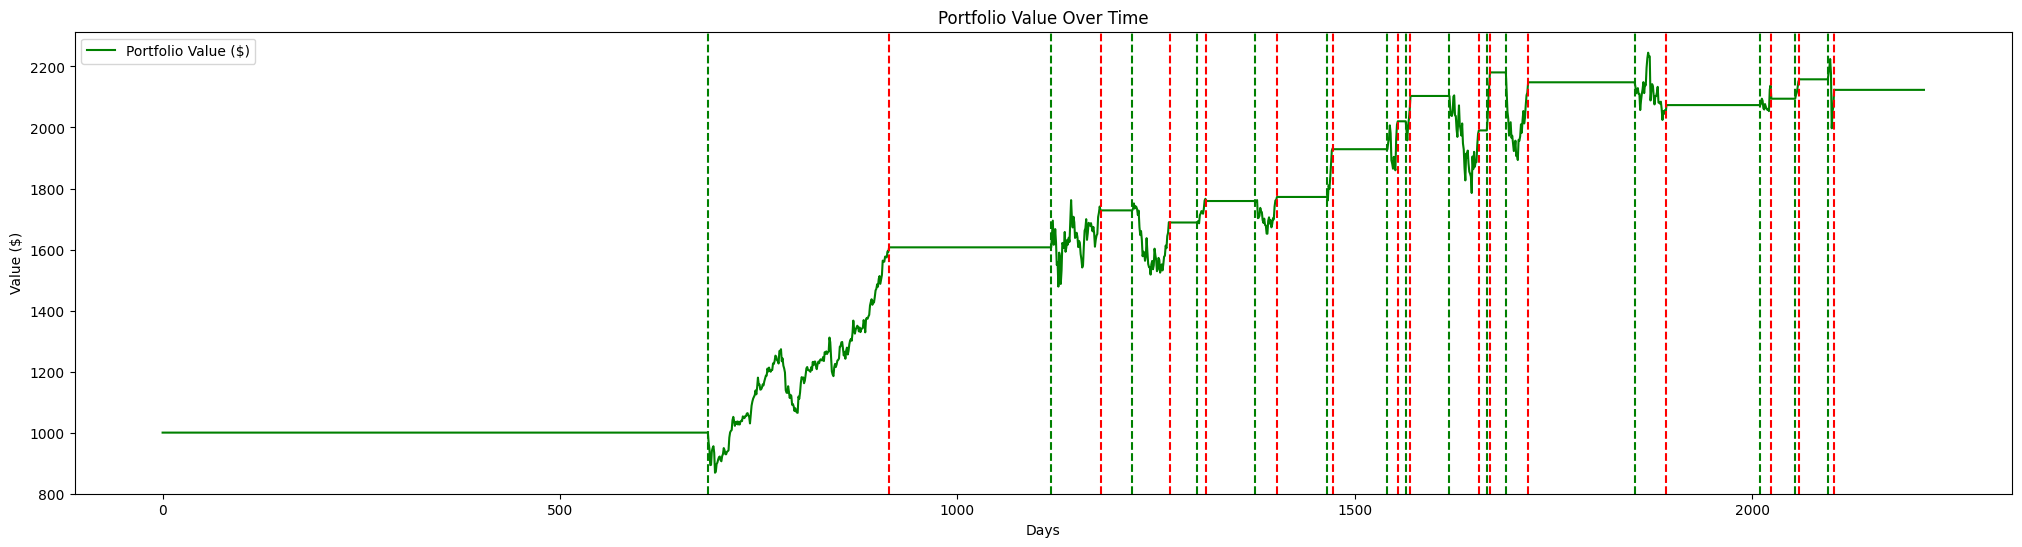

In [263]:

# Parameters
stock = 0
money = 1000
money_log = []
portfolio_value_log = []
buy_threshold = -0.1
sell_threshold = 0.1
sell_counter = 0
buy_counter = 0
buy_threshold_c = 4
sell_threshold_c = 4

# Predicted and actual prices
diff_pred = y2_pred_flat  # Use predictions from the second model
open_prices = X2_test[:, 0, 0].tolist()

# Trade logs
buy_log = []
sell_log = []

# Simulate trading strategy
for i in range(0, len(diff_pred) - 1):
    # Buy logic
    if diff_pred[i] < buy_threshold and money >= open_prices[i]:
        buy_counter += 1
        if buy_counter >= buy_threshold_c:
            while money >= open_prices[i]:
                stock += 1
                money -= open_prices[i]
            buy_log.append(i)
    else:
        buy_counter = 0

    # Sell logic
    if diff_pred[i] > sell_threshold:
        sell_counter += 1
        if sell_counter >= sell_threshold_c and stock > 0:
            money += open_prices[i] * stock
            sell_log.append(i)
            stock = 0
    else:
        sell_counter = 0

    # Portfolio value calculation
    portfolio_value = money + stock * open_prices[i]
    portfolio_value_log.append(portfolio_value)
    money_log.append(money)

# Final sell if still holding stock
if stock > 0:
    money += stock * open_prices[-1]
    sell_log.append(i)

    portfolio_value = money
else:
    portfolio_value = portfolio_value_log[-1]

# Print final results
print(f"Final Money: ${money:.2f}")
print(f"Final Portfolio Value: ${portfolio_value:.2f}")

# Plot portfolio value
plt.figure(figsize=(25, 6))
plt.plot(portfolio_value_log, label="Portfolio Value ($)", linestyle="-", color="green")
plt.title("Portfolio Value Over Time")
plt.xlabel("Days")
plt.ylabel("Value ($)")

for xi in sell_log:
    plt.axvline(x=xi, linestyle='--', color='r')
for xi in buy_log:
    plt.axvline(x=xi, linestyle='--', color='g')

plt.legend()
plt.show()

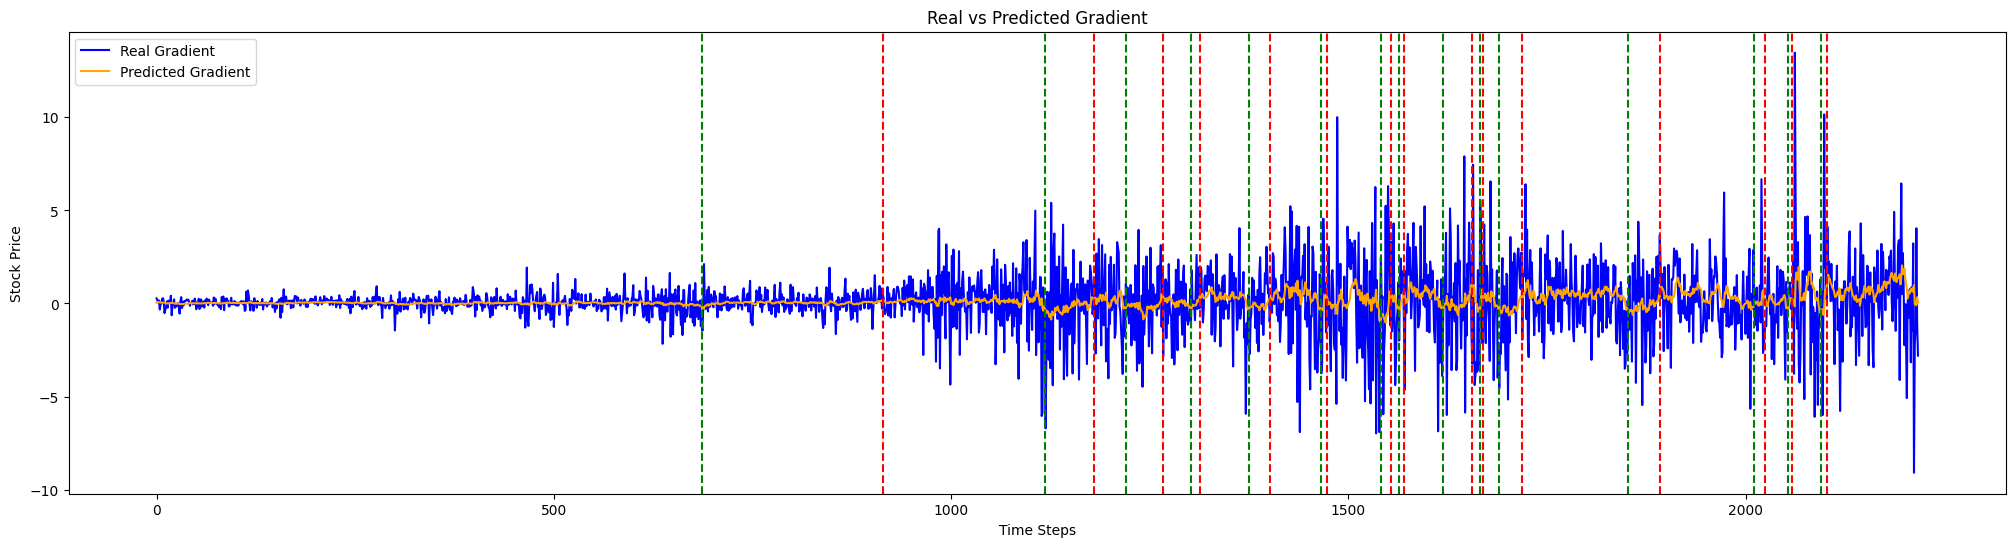

Mean Absolute Error (MAE): 1.1037884566839717
Mean Squared Error (MSE): 2.978524535678485


In [264]:
# Create a shared x-axis based on the actual number of samples
x_axis = range(len(y2_test_flat))

# Plot the real vs predicted values
plt.figure(figsize=(25, 6))
plt.plot(x_axis, y2_test_flat, label="Real Gradient", color="blue")
plt.plot(x_axis, y2_pred_flat, label="Predicted Gradient", color="orange")
plt.title("Real vs Predicted Gradient")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")                             
plt.legend()

for xi in sell_log:
    plt.axvline(x=xi, linestyle='--', color='r', label='Bot close')
for xi in buy_log:
    plt.axvline(x=xi, linestyle='--', color='g', label='Bot open')
plt.show()

mae = mean_absolute_error(y2_test, y2_pred.flatten())
mse = mean_squared_error(y2_test, y2_pred.flatten())
rmse = np.sqrt(mse)
r2 = r2_score(y2_test, y2_pred.flatten())
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')

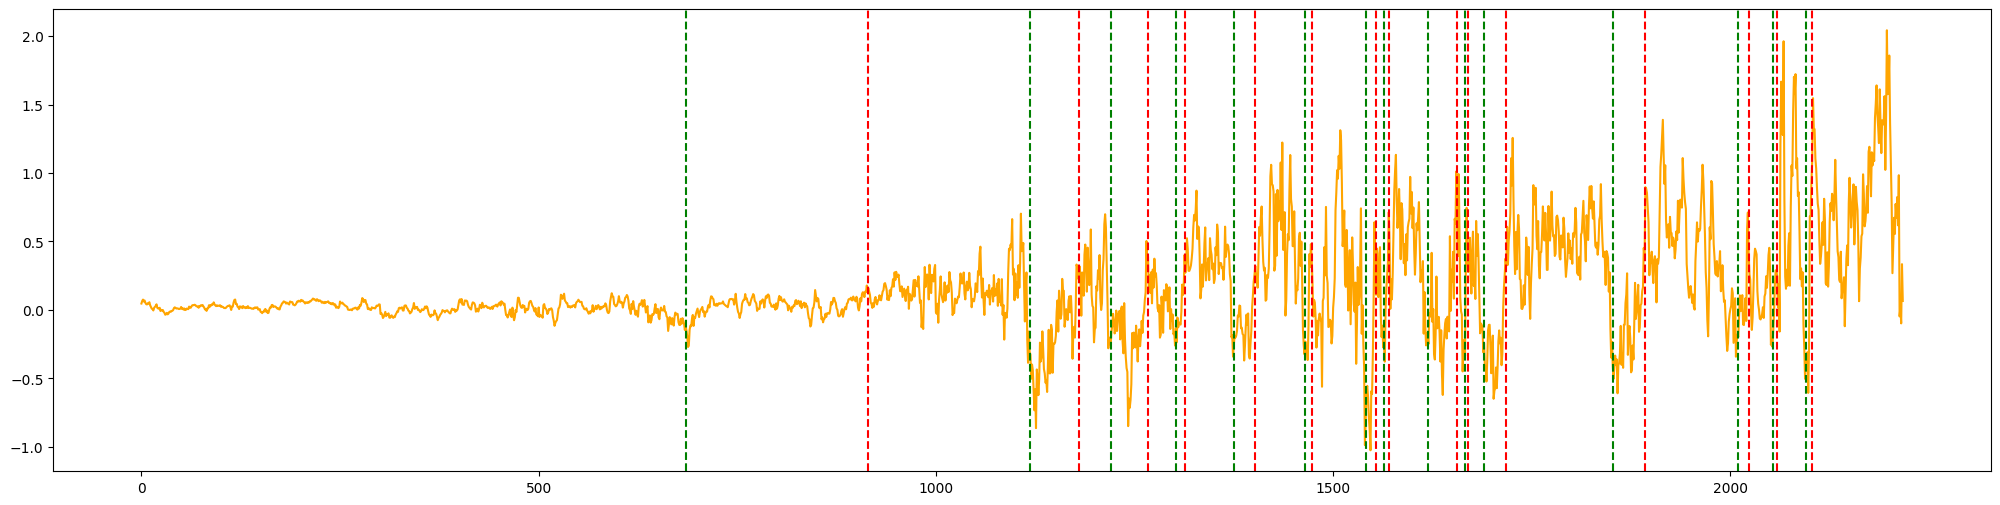

In [265]:
plt.figure(figsize=(25, 6))
plt.plot(x_axis, y2_pred_flat, label="Predicted Gradient", color="orange")
for xi in sell_log:
    plt.axvline(x=xi, linestyle='--', color='r', label='Bot close')
for xi in buy_log:
    plt.axvline(x=xi, linestyle='--', color='g', label='Bot open')

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


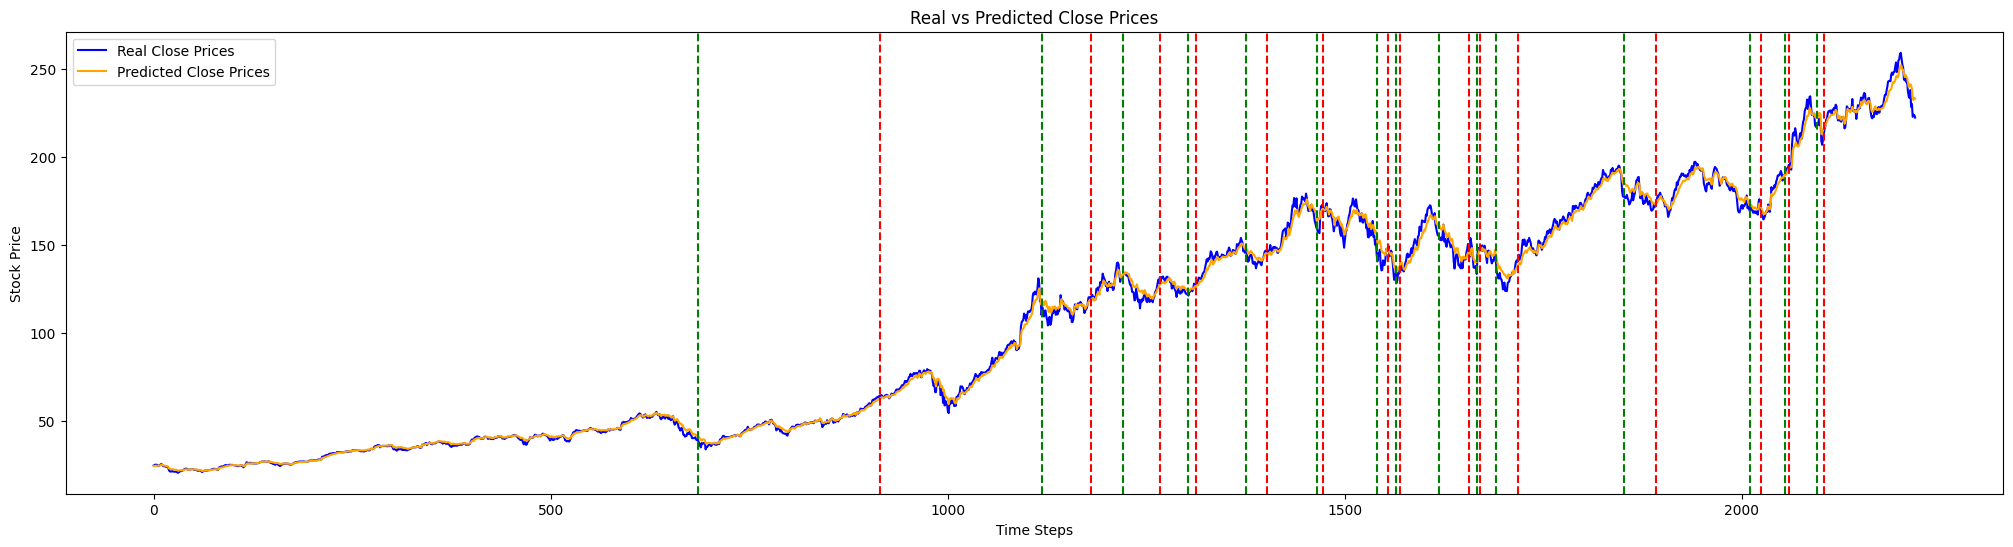

In [266]:
y_pred = model.predict(X_test)
plt.figure(figsize=(25, 6))
plt.plot(range(len(y_test)), y_test, label="Real Close Prices", color="blue")
plt.plot(range(len(y_pred)), y_pred.flatten(), label="Predicted Close Prices", color="orange")
plt.title("Real vs Predicted Close Prices")
plt.xlabel("Time Steps")    
plt.ylabel("Stock Price")
plt.legend()

for xi in sell_log:
    plt.axvline(x=xi, linestyle='--', color='r', label='Bot close')
for xi in buy_log:
    plt.axvline(x=xi, linestyle='--', color='g', label='Bot open')
plt.show()